# Test Multi Spectral Images

### MRobalinho  14-4-2019

### Colors
https://www.rapidtables.com/web/color/html-color-codes.html

https://www.rapidtables.com/web/color/RGB_Color.html

In [1]:
# Add libraries
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from openpyxl import load_workbook
import cv2

In [2]:
# Verify my current folder
currDir = os.path.dirname(os.path.realpath("__file__"))
mypath = currDir
print(currDir) 

C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook


In [3]:
# Path to the image files
folder = "Test_image02"
path = mypath + "/" + folder + "/"
path

'C:\\Users\\manuel.robalinho\\Google Drive\\UPT_Portucalense\\Trabalho final\\Classificacao_Sucata\\Jupyter_Notebook/Test_image02/'

In [4]:
# Read image with PIL
from PIL import Image, ImageFilter, ImageOps
def read_pil_image(file1):
    print('Reading image:', file1)
    try:
        original = Image.open(file1)
    except:
        print ("Unable to load image")
    return original

In [5]:
# Increase the contrast image
# im - image
# xvalue = contrast value
# https://pillow.readthedocs.io/en/4.0.x/reference/ImageEnhance.html
from PIL import ImageEnhance

def contrast(im, xvalue):
    enh = ImageEnhance.Contrast(im)
    # enh.enhance(1.0).show("30% more contrast")
    x_enh = enh.enhance(xvalue)
    return x_enh

In [6]:
# Read image folder
import glob, os
def get_image_folder(xfile1):
    #currDir = os.path.dirname(os.path.realpath("__file__"))
    
    # Path to the image files
   # folder = "imagedata03"
    path = currDir + "/" + folder + "/"
    # File
    file1 = path + xfile1
    #print('Get image folder file1=',file1)
    return file1

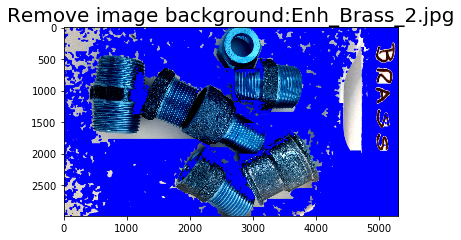

In [7]:
# Contour image and background
import cv2
def remove_background_image(path, xfile):
    # Read with cv2
    #== Parameters           
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 100  # Original 200, changed to 100
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0,0.0,1.0) # In BGR format

    #-- Read image
    img = cv2.imread(path+xfile)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection 
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area 
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))

    #-- Smooth mask, then blur it
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background
    mask_stack  = mask_stack.astype('float32') / 255.0         
    img         = img.astype('float32') / 255.0    
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR)  
    masked = (masked * 255).astype('uint8')                    
    
    cv2.imwrite(path+"MASK_"+xfile,masked)
    return(masked, edges)

xfile = 'Enh_Brass_2.jpg'
masked, edges = remove_background_image(path,xfile)
%matplotlib inline
plt.imshow(masked)
plt.title('Remove image background:'+xfile,fontsize=20)
plt.show()

In [9]:
# Obtain main color from image file
# https://convertingcolors.com/rgb-color-169_171_170.html
# https://pillow.readthedocs.io/en/4.0.x/reference/Image.html#PIL.Image.Image.getcolors
from PIL import Image

def get_main_color(path, file):
    img = Image.open(path+file)
    colors = img.getcolors( 1024*1024) #put a higher value if there are many colors in your image

    max_occurence, most_present = 0, 0
    try:
        for c in colors:
            if c[0] > max_occurence:
                (max_occurence, most_present) = c
        print('Get main Color file:', file, ' RGB:', most_present)        
        return most_present 
    except TypeError:
        raise Exception("Too many colors in the image")

In [10]:
# COLOR NAME
import webcolors
def get_color_name(rgb_x):
    min_colours = {}
    for key, name in webcolors.css21_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - rgb_x[0]) ** 2
        gd = (g_c - rgb_x[1]) ** 2
        bd = (b_c - rgb_x[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    print('Color name from RGB:',rgb_x,'  is :',min_colours[min(min_colours.keys())])
    return min_colours[min(min_colours.keys())]

In [11]:
#!/usr/bin/python

# Return one 24-bit color value 
def rgbToDecimal(x_rgb):
    r,g,b = rgbToRGB(x_rgb)
    #print('Color:', r,g,b)
    return (r << 16) + (g << 8) + b

# Convert 24-bit color value to RGB
def colorToRGB(c):
    r = c >> 16
    c -= r * 65536;
    g = c / 256
    c -= g * 256;
    b = c
    return [r, g, b]

def rgbToRGB(x_rgb):
    x_rgb = list(x_rgb)
    r = x_rgb[0]
    g = x_rgb[1]
    b = x_rgb[2]

    print(x_rgb, r,g,b)
    return r, g, b

def getRGBfromI(RGBint):
    blue =  RGBint & 255
    green = (RGBint >> 8) & 255
    red =   (RGBint >> 16) & 255
    return red, green, blue

def getIfromRGB(rgb):
    red = rgb[0]
    green = rgb[1]
    blue = rgb[2]
    print(red, green, blue)
    RGBint = (red<<16) + (green<<8) + blue
    return RGBint

In [12]:
# Return RGB separately
def return_rgb_from_RGB(rgb):
    p_rgb = list(rgb)
    red   = p_rgb[0]
    green = p_rgb[1]
    blue  = p_rgb[2]
    return red, green, blue

In [12]:
# Return distance from 2 colors

# http://hanzratech.in/2015/01/16/color-difference-between-2-colors-using-python.html
# https://python-colormath.readthedocs.io/en/latest/delta_e.html#delta-e-cie-2000

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

def delta_2_colors(rgb_1, rgb_2):
    #---- first color
    xr, xg, xb = return_rgb_from_RGB(rgb_1)
    # Red Color
    color1_rgb = sRGBColor(xr, xg, xb)

    #--- other color
    rgb_1 = rgb_2
    xr, xg, xb = return_rgb_from_RGB(rgb_1)
    # Blue Color
    color2_rgb = sRGBColor(xr, xg, xb)

    # Convert from RGB to Lab Color Space
    color1_lab = convert_color(color1_rgb, LabColor)

    # Convert from RGB to Lab Color Space
    color2_lab = convert_color(color2_rgb, LabColor)

    # Find the color difference
    delta_e = delta_e_cie2000(color1_lab, color2_lab)

    #print("The difference between the 2 color = ", delta_e)
    return delta_e

Ler White background: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Copper_3.jpg
Save image to disk: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/White_Mask_Copper_3.jpg


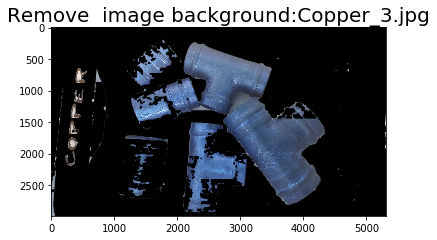

In [8]:
# Remove Background - Put White background
#https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image
    
import cv2
import numpy as np

def white_background(file1):
    print('Ler White background:', file1)
    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 100
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format (0,0,0) color WHITE

    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img  = cv2.imread(file1)

    # Create name file masked
    f2_file = 'White_Mask_'+f1_file
    file2 = get_image_folder(f2_file)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
            ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))

    #-- Smooth mask, then blur it
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background
    mask_stack  = mask_stack.astype('float32') / 255.0         
    img         = img.astype('float32') / 255.0    
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR)  
    masked = (masked * 255).astype('uint8')  

    # save to disk
    print('Save image to disk:', file2)
    #cv2.imshow('img', masked)           # Display
    #cv2.waitKey()
    cv2.imwrite(file2,masked)
    return f2_file, masked

# TEST
f1_file = 'Copper_3.jpg'
file1 = get_image_folder(f1_file)
f2_file, masked = white_background(file1)

# show on screen (optional in jupiter)
%matplotlib inline
plt.imshow(masked)
plt.title('Remove  image background:'+f1_file,fontsize=20)
plt.show()


In [36]:
c_blue

array([[168, 167, 167, ..., 244, 244, 244],
       [173, 172, 172, ..., 244, 244, 244],
       [176, 174, 174, ..., 244, 244, 244],
       ...,
       [176, 179, 178, ..., 225, 225, 225],
       [177, 178, 177, ..., 223, 224, 225],
       [178, 178, 177, ..., 221, 222, 225]], dtype=uint8)

Red background: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Brass_2.jpg
Save image to disk: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Mask_Brass_2.jpg


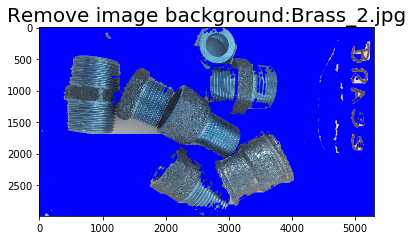

In [10]:
# Remove Background - Put red background
#https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image
    
import cv2
import numpy as np

def red_background(file1):
    print('Red background:', file1)
    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 100
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0,0.0,1.0) # In BGR format

    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img  = cv2.imread(file1)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))

    #-- Smooth mask, then blur it
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background
    mask_stack  = mask_stack.astype('float32') / 255.0         
    img         = img.astype('float32') / 255.0    
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR)  
    masked = (masked * 255).astype('uint8')    
    
    # Create name file masked
    f2_file = 'Mask_'+f1_file
    file2 = get_image_folder(f2_file)
    
    # Write masked image on disk
    print('Save image to disk:', file2)
    cv2.imwrite(file2, masked)           # Save
    # Return name file masked and image masked

    return f2_file, masked 

# Test
f1_file = 'Brass_2.jpg'
file1 = get_image_folder(f1_file)
f2_file, masked = red_background(file1)

# show on screen (optional in jupiter)
%matplotlib inline
plt.imshow(masked)
plt.title('Remove image background:'+f1_file,fontsize=20)
plt.show()

#   Start test

In [17]:
f1_file = 'Brass_1.jpg'
file1 = get_image_folder(f1_file)

C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Brass_2.jpg


Reading image: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image/Brass_1.jpg


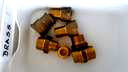

In [166]:
im = read_pil_image(file1)
x_enh = contrast(im,2.0)
x_enh

In [167]:
# Get Max Color
im = Image.open(file1)
n, color = max(im.getcolors(im.size[0]*im.size[1]))
print(color)

(168, 167, 163)


In [24]:
# Remove Background - Put red background
#https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image

f1_file = 'Brass_2.jpg'
file1 = get_image_folder(f1_file)

f2_file, masked = red_background(file1)

cv2.imshow('img', mask)                                   # Display
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Brass_2.jpg
Red background: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Brass_2.jpg
C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/Mask_Brass_2.jpg


-1

In [169]:
f2_file

'Mask_Brass_1.jpg'

In [170]:
# Get main color (dominant color)
# https://convertingcolors.com/rgb-color-169_171_170.html
rgb2 = get_main_color(path, f2_file)

Get main Color file: Mask_Brass_1.jpg  RGB: (254, 0, 0)


In [171]:
x3 = get_color_name(rgb2)
x3

Color name from RGB: (254, 0, 0)   is : red


'red'

In [132]:
# https://convertingcolors.com/rgb-color-169_171_170.html

img = Image.open(path+f2_file)
colors = img.getcolors( 1024*1024) #put a higher value if there are many colors in your image
#-----
# --- Obtain RGB red and decimal RGB red
rgb_red = (254, 0, 0)   # Configure red color

# --- Obtain RGB Background and decimal RGB Backgroundred
rgb_back = (216, 220, 223)  # Configure background color

#-----
# Create list with colors without RED color (near red color)
list_non_red = list()
#-----
# Create list with colors without Background color (near Background color)
list_non_back = list()
#
print('List without red color', rgb_red)
# Convert list to decimal color
for color in colors:
    # Diference between colors
   # print(color[1])
    rgb = color[1]
    zz = 0
    zz = delta_2_colors(rgb_red, rgb)
    # create new list whithout nead Red color (+- 10)    
    if zz > 90:
        list_non_red.append(rgb) 
#        print('OK Color RED:',rgb_red,'   other color:',rgb, '  Dif Color:',zz)
#    else:
#        print('NO Color:',rgb_red,'   other color:',rgb, '  Dif Color:',zz)


#-----
# Convert list to decimal color and with out background color
print('List without background color',rgb_back)
for color in list_non_red:
    rgb = color
    # Diference between colors
    zz = 0
    zz = delta_2_colors(rgb_back, rgb)
    # create new list whithout nead Background color (+- 10)    
    if zz > 100:
        list_non_back.append(rgb) 
        #print('OK Color BK:',rgb_back,'   other color:',rgb, '  Dif Color:',zz)
#    else:
     #  print('NO Color:',rgb_red,'   other color:',rgb, '  Dif Color:',zz)
       
#-----
print('Count ocurrencies for color')
most_present = 0

# Most common color in the list
import collections
x = collections.Counter(list_non_back)
print('5 Most commoun colors:', x.most_common(5))  # Five most common colors
most_present = x.most_common(1)
xrgb = list_non_back[0] # common color
# -------
print('Get main Color file:', f2_file, ' RGB:', most_present, xrgb)
xt = get_color_name(xrgb)

NameError: name 'f2_file' is not defined

In [345]:
list_non_back[0]

(226, 215, 223)

In [11]:
# Most common color in the list
import collections
x=collections.Counter(list_non_back)
print(x.most_common(5))  # Five most common colors

NameError: name 'list_non_back' is not defined

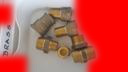

In [66]:
img

In [116]:
# https://convertingcolors.com/rgb-color-169_171_170.html
img = Image.open(path+f2_file)
colors = img.getcolors( 1024*1024) #put a higher value if there are many colors in your image

In [110]:
# Obtain RGB red and decimal RGB  
rgb_red = (254, 0, 0)
dec_red = rgbToDecimal(rgb_red)
dec_red

[254, 0, 0] 254 0 0
Color: 254 0 0


16646144

In [117]:
# Create list with colors without RED color (near red color)
my_list = list()

# Convert list to decimal color
for color in colors:
    rgb = color[1]
    dec = rgbToDecimal(rgb)
    zz = dec_red - dec
    if zz < 0:
        zz = zz * -1
    # create new list whithout nead Red color (+- 50000)    
    if zz > 50000:
        my_list.append(rgb) 
        #print('Decimal RED:',dec_red,'  , Decimal color:',dec, '  Dif Color:',zz)
        

[216, 220, 223] 216 220 223
Color: 216 220 223
[207, 216, 223] 207 216 223
Color: 207 216 223
[226, 215, 223] 226 215 223
Color: 226 215 223
[208, 215, 223] 208 215 223
Color: 208 215 223
[211, 214, 223] 211 214 223
Color: 211 214 223
[205, 214, 223] 205 214 223
Color: 205 214 223
[213, 213, 223] 213 213 223
Color: 213 213 223
[208, 212, 223] 208 212 223
Color: 208 212 223
[207, 211, 223] 207 211 223
Color: 207 211 223
[208, 189, 191] 208 189 191
Color: 208 189 191
[189, 189, 191] 189 189 191
Color: 189 189 191
[190, 188, 191] 190 188 191
Color: 190 188 191
[184, 188, 191] 184 188 191
Color: 184 188 191
[182, 187, 191] 182 187 191
Color: 182 187 191
[207, 186, 191] 207 186 191
Color: 207 186 191
[201, 186, 191] 201 186 191
Color: 201 186 191
[195, 186, 191] 195 186 191
Color: 195 186 191
[185, 186, 191] 185 186 191
Color: 185 186 191
[183, 186, 191] 183 186 191
Color: 183 186 191
[221, 184, 191] 221 184 191
Color: 221 184 191
[181, 184, 191] 181 184 191
Color: 181 184 191
[183, 183, 19

[110, 83, 62] 110 83 62
Color: 110 83 62
[104, 83, 62] 104 83 62
Color: 104 83 62
[99, 82, 62] 99 82 62
Color: 99 82 62
[121, 81, 30] 121 81 30
Color: 121 81 30
[106, 79, 62] 106 79 62
Color: 106 79 62
[105, 79, 62] 105 79 62
Color: 105 79 62
[95, 78, 62] 95 78 62
Color: 95 78 62
[94, 78, 62] 94 78 62
Color: 94 78 62
[90, 78, 62] 90 78 62
Color: 90 78 62
[88, 76, 62] 88 76 62
Color: 88 76 62
[89, 75, 62] 89 75 62
Color: 89 75 62
[102, 74, 62] 102 74 62
Color: 102 74 62
[201, 73, 62] 201 73 62
Color: 201 73 62
[87, 73, 62] 87 73 62
Color: 87 73 62
[89, 72, 62] 89 72 62
Color: 89 72 62
[192, 69, 62] 192 69 62
Color: 192 69 62
[76, 67, 62] 76 67 62
Color: 76 67 62
[210, 65, 62] 210 65 62
Color: 210 65 62
[91, 65, 30] 91 65 30
Color: 91 65 30
[219, 64, 62] 219 64 62
Color: 219 64 62
[218, 64, 62] 218 64 62
Color: 218 64 62
[213, 63, 62] 213 63 62
Color: 213 63 62
[91, 62, 30] 91 62 30
Color: 91 62 30
[231, 61, 62] 231 61 62
Color: 231 61 62
[234, 60, 62] 234 60 62
Color: 234 60 62
[128, 59

[227, 118, 124] 227 118 124
Color: 227 118 124
[158, 116, 92] 158 116 92
Color: 158 116 92
[140, 116, 92] 140 116 92
Color: 140 116 92
[138, 116, 92] 138 116 92
Color: 138 116 92
[145, 114, 60] 145 114 60
Color: 145 114 60
[134, 113, 92] 134 113 92
Color: 134 113 92
[128, 113, 92] 128 113 92
Color: 128 113 92
[130, 112, 92] 130 112 92
Color: 130 112 92
[129, 112, 92] 129 112 92
Color: 129 112 92
[138, 110, 60] 138 110 60
Color: 138 110 60
[127, 110, 92] 127 110 92
Color: 127 110 92
[149, 109, 60] 149 109 60
Color: 149 109 60
[128, 109, 92] 128 109 92
Color: 128 109 92
[122, 109, 92] 122 109 92
Color: 122 109 92
[145, 108, 92] 145 108 92
Color: 145 108 92
[124, 108, 92] 124 108 92
Color: 124 108 92
[128, 106, 92] 128 106 92
Color: 128 106 92
[132, 105, 60] 132 105 60
Color: 132 105 60
[119, 105, 92] 119 105 92
Color: 119 105 92
[113, 105, 92] 113 105 92
Color: 113 105 92
[146, 103, 60] 146 103 60
Color: 146 103 60
[105, 101, 92] 105 101 92
Color: 105 101 92
[126, 99, 92] 126 99 92
Color

Color: 192 97 91
[189, 96, 91] 189 96 91
Color: 189 96 91
[202, 94, 91] 202 94 91
Color: 202 94 91
[127, 94, 59] 127 94 59
Color: 127 94 59
[117, 93, 59] 117 93 59
Color: 117 93 59
[206, 92, 91] 206 92 91
Color: 206 92 91
[97, 91, 91] 97 91 91
Color: 97 91 91
[232, 89, 91] 232 89 91
Color: 232 89 91
[227, 88, 91] 227 88 91
Color: 227 88 91
[119, 88, 59] 119 88 59
Color: 119 88 59
[223, 87, 91] 223 87 91
Color: 223 87 91
[112, 86, 59] 112 86 59
Color: 112 86 59
[87, 84, 91] 87 84 91
Color: 87 84 91
[154, 83, 91] 154 83 91
Color: 154 83 91
[113, 83, 91] 113 83 91
Color: 113 83 91
[160, 82, 59] 160 82 59
Color: 160 82 59
[102, 80, 59] 102 80 59
Color: 102 80 59
[130, 77, 27] 130 77 27
Color: 130 77 27
[95, 76, 59] 95 76 59
Color: 95 76 59
[91, 75, 59] 91 75 59
Color: 91 75 59
[87, 75, 59] 87 75 59
Color: 87 75 59
[153, 74, 59] 153 74 59
Color: 153 74 59
[93, 74, 59] 93 74 59
Color: 93 74 59
[91, 73, 59] 91 73 59
Color: 91 73 59
[85, 73, 59] 85 73 59
Color: 85 73 59
[210, 72, 59] 210 72 59

Color: 172 162 153
[171, 162, 153] 171 162 153
Color: 171 162 153
[166, 162, 153] 166 162 153
Color: 166 162 153
[165, 162, 153] 165 162 153
Color: 165 162 153
[168, 161, 153] 168 161 153
Color: 168 161 153
[177, 160, 153] 177 160 153
Color: 177 160 153
[169, 160, 153] 169 160 153
Color: 169 160 153
[163, 160, 153] 163 160 153
Color: 163 160 153
[166, 159, 153] 166 159 153
Color: 166 159 153
[164, 159, 153] 164 159 153
Color: 164 159 153
[161, 158, 153] 161 158 153
Color: 161 158 153
[159, 158, 153] 159 158 153
Color: 159 158 153
[168, 157, 153] 168 157 153
Color: 168 157 153
[158, 157, 153] 158 157 153
Color: 158 157 153
[173, 155, 153] 173 155 153
Color: 173 155 153
[165, 155, 153] 165 155 153
Color: 165 155 153
[156, 155, 153] 156 155 153
Color: 156 155 153
[222, 154, 153] 222 154 153
Color: 222 154 153
[174, 154, 153] 174 154 153
Color: 174 154 153
[158, 154, 153] 158 154 153
Color: 158 154 153
[206, 150, 153] 206 150 153
Color: 206 150 153
[228, 147, 153] 228 147 153
Color: 228 14

Color: 104 68 56
[74, 68, 56] 74 68 56
Color: 74 68 56
[193, 65, 56] 193 65 56
Color: 193 65 56
[162, 65, 56] 162 65 56
Color: 162 65 56
[214, 61, 56] 214 61 56
Color: 214 61 56
[89, 60, 56] 89 60 56
Color: 89 60 56
[221, 59, 56] 221 59 56
Color: 221 59 56
[217, 59, 56] 217 59 56
Color: 217 59 56
[230, 58, 56] 230 58 56
Color: 230 58 56
[223, 58, 56] 223 58 56
Color: 223 58 56
[228, 56, 56] 228 56 56
Color: 228 56 56
[226, 56, 56] 226 56 56
Color: 226 56 56
[222, 56, 56] 222 56 56
Color: 222 56 56
[237, 54, 56] 237 54 56
Color: 237 54 56
[57, 40, 24] 57 40 24
Color: 57 40 24
[240, 28, 24] 240 28 24
Color: 240 28 24
[53, 28, 24] 53 28 24
Color: 53 28 24
[242, 27, 24] 242 27 24
Color: 242 27 24
[239, 27, 24] 239 27 24
Color: 239 27 24
[245, 26, 24] 245 26 24
Color: 245 26 24
[241, 26, 24] 241 26 24
Color: 241 26 24
[240, 26, 24] 240 26 24
Color: 240 26 24
[243, 25, 24] 243 25 24
Color: 243 25 24
[249, 23, 24] 249 23 24
Color: 249 23 24
[246, 20, 24] 246 20 24
Color: 246 20 24
[245, 20, 2

Color: 137 129 118
[146, 128, 118] 146 128 118
Color: 146 128 118
[145, 128, 118] 145 128 118
Color: 145 128 118
[140, 127, 118] 140 127 118
Color: 140 127 118
[139, 126, 118] 139 126 118
Color: 139 126 118
[182, 125, 118] 182 125 118
Color: 182 125 118
[164, 125, 86] 164 125 86
Color: 164 125 86
[183, 124, 118] 183 124 118
Color: 183 124 118
[184, 123, 118] 184 123 118
Color: 184 123 118
[126, 123, 118] 126 123 118
Color: 126 123 118
[181, 122, 118] 181 122 118
Color: 181 122 118
[161, 120, 118] 161 120 118
Color: 161 120 118
[150, 120, 86] 150 120 86
Color: 150 120 86
[145, 119, 86] 145 119 86
Color: 145 119 86
[141, 118, 86] 141 118 86
Color: 141 118 86
[227, 117, 118] 227 117 118
Color: 227 117 118
[155, 117, 54] 155 117 54
Color: 155 117 54
[119, 117, 118] 119 117 118
Color: 119 117 118
[225, 115, 118] 225 115 118
Color: 225 115 118
[224, 115, 118] 224 115 118
Color: 224 115 118
[136, 115, 86] 136 115 86
Color: 136 115 86
[205, 113, 118] 205 113 118
Color: 205 113 118
[139, 113, 8

[130, 108, 85] 130 108 85
Color: 130 108 85
[105, 108, 117] 105 108 117
Color: 105 108 117
[125, 107, 85] 125 107 85
Color: 125 107 85
[137, 106, 85] 137 106 85
Color: 137 106 85
[128, 106, 85] 128 106 85
Color: 128 106 85
[123, 105, 85] 123 105 85
Color: 123 105 85
[144, 104, 53] 144 104 53
Color: 144 104 53
[125, 104, 85] 125 104 85
Color: 125 104 85
[120, 103, 85] 120 103 85
Color: 120 103 85
[115, 102, 85] 115 102 85
Color: 115 102 85
[146, 99, 53] 146 99 53
Color: 146 99 53
[123, 96, 53] 123 96 53
Color: 123 96 53
[107, 94, 85] 107 94 85
Color: 107 94 85
[202, 89, 85] 202 89 85
Color: 202 89 85
[127, 89, 53] 127 89 53
Color: 127 89 53
[113, 89, 53] 113 89 53
Color: 113 89 53
[226, 86, 85] 226 86 85
Color: 226 86 85
[145, 84, 53] 145 84 53
Color: 145 84 53
[232, 83, 85] 232 83 85
Color: 232 83 85
[221, 82, 85] 221 82 85
Color: 221 82 85
[101, 77, 53] 101 77 53
Color: 101 77 53
[136, 74, 53] 136 74 53
Color: 136 74 53
[93, 72, 53] 93 72 53
Color: 93 72 53
[154, 71, 53] 154 71 53
Col

[139, 95, 50] 139 95 50
Color: 139 95 50
[136, 94, 82] 136 94 82
Color: 136 94 82
[120, 88, 50] 120 88 50
Color: 120 88 50
[199, 86, 82] 199 86 82
Color: 199 86 82
[105, 86, 82] 105 86 82
Color: 105 86 82
[87, 86, 82] 87 86 82
Color: 87 86 82
[118, 85, 50] 118 85 50
Color: 118 85 50
[196, 84, 82] 196 84 82
Color: 196 84 82
[133, 83, 50] 133 83 50
Color: 133 83 50
[219, 79, 82] 219 79 82
Color: 219 79 82
[102, 74, 50] 102 74 50
Color: 102 74 50
[94, 74, 50] 94 74 50
Color: 94 74 50
[189, 70, 50] 189 70 50
Color: 189 70 50
[88, 70, 50] 88 70 50
Color: 88 70 50
[96, 69, 50] 96 69 50
Color: 96 69 50
[85, 68, 50] 85 68 50
Color: 85 68 50
[78, 66, 50] 78 66 50
Color: 78 66 50
[81, 65, 50] 81 65 50
Color: 81 65 50
[74, 65, 50] 74 65 50
Color: 74 65 50
[76, 64, 50] 76 64 50
Color: 76 64 50
[74, 62, 50] 74 62 50
Color: 74 62 50
[69, 61, 50] 69 61 50
Color: 69 61 50
[220, 57, 50] 220 57 50
Color: 220 57 50
[221, 56, 50] 221 56 50
Color: 221 56 50
[218, 55, 50] 218 55 50
Color: 218 55 50
[230, 52

[125, 114, 112] 125 114 112
Color: 125 114 112
[112, 112, 112] 112 112 112
Color: 112 112 112
[142, 111, 80] 142 111 80
Color: 142 111 80
[229, 110, 112] 229 110 112
Color: 229 110 112
[135, 110, 80] 135 110 80
Color: 135 110 80
[218, 109, 112] 218 109 112
Color: 218 109 112
[136, 109, 80] 136 109 80
Color: 136 109 80
[132, 108, 80] 132 108 80
Color: 132 108 80
[127, 107, 80] 127 107 80
Color: 127 107 80
[130, 106, 80] 130 106 80
Color: 130 106 80
[137, 105, 48] 137 105 48
Color: 137 105 48
[131, 105, 80] 131 105 80
Color: 131 105 80
[162, 104, 80] 162 104 80
Color: 162 104 80
[126, 104, 80] 126 104 80
Color: 126 104 80
[124, 104, 80] 124 104 80
Color: 124 104 80
[143, 102, 48] 143 102 48
Color: 143 102 48
[127, 102, 80] 127 102 80
Color: 127 102 80
[120, 102, 80] 120 102 80
Color: 120 102 80
[126, 99, 80] 126 99 80
Color: 126 99 80
[145, 98, 80] 145 98 80
Color: 145 98 80
[109, 98, 80] 109 98 80
Color: 109 98 80
[141, 97, 48] 141 97 48
Color: 141 97 48
[135, 97, 48] 135 97 48
Color: 1

[170, 152, 142] 170 152 142
Color: 170 152 142
[152, 152, 142] 152 152 142
Color: 152 152 142
[161, 151, 142] 161 151 142
Color: 161 151 142
[160, 151, 142] 160 151 142
Color: 160 151 142
[179, 150, 110] 179 150 110
Color: 179 150 110
[157, 150, 142] 157 150 142
Color: 157 150 142
[173, 147, 110] 173 147 110
Color: 173 147 110
[150, 147, 142] 150 147 142
Color: 150 147 142
[146, 147, 142] 146 147 142
Color: 146 147 142
[157, 146, 142] 157 146 142
Color: 157 146 142
[147, 146, 142] 147 146 142
Color: 147 146 142
[168, 144, 110] 168 144 110
Color: 168 144 110
[144, 144, 142] 144 144 142
Color: 144 144 142
[148, 142, 142] 148 142 142
Color: 148 142 142
[222, 140, 142] 222 140 142
Color: 222 140 142
[195, 139, 142] 195 139 142
Color: 195 139 142
[214, 138, 142] 214 138 142
Color: 214 138 142
[162, 138, 110] 162 138 110
Color: 162 138 110
[215, 136, 142] 215 136 142
Color: 215 136 142
[174, 135, 78] 174 135 78
Color: 174 135 78
[154, 134, 110] 154 134 110
Color: 154 134 110
[144, 129, 110] 

[216, 226, 236] 216 226 236
Color: 216 226 236
[214, 224, 236] 214 224 236
Color: 214 224 236
[206, 206, 204] 206 206 204
Color: 206 206 204
[205, 203, 204] 205 203 204
Color: 205 203 204
[215, 198, 204] 215 198 204
Color: 215 198 204
[203, 198, 204] 203 198 204
Color: 203 198 204
[191, 198, 204] 191 198 204
Color: 191 198 204
[194, 197, 204] 194 197 204
Color: 194 197 204
[191, 195, 204] 191 195 204
Color: 191 195 204
[184, 181, 172] 184 181 172
Color: 184 181 172
[180, 177, 172] 180 177 172
Color: 180 177 172
[178, 177, 172] 178 177 172
Color: 178 177 172
[175, 177, 172] 175 177 172
Color: 175 177 172
[173, 175, 172] 173 175 172
Color: 173 175 172
[168, 174, 172] 168 174 172
Color: 168 174 172
[183, 173, 172] 183 173 172
Color: 183 173 172
[171, 173, 172] 171 173 172
Color: 171 173 172
[213, 171, 172] 213 171 172
Color: 213 171 172
[173, 171, 172] 173 171 172
Color: 173 171 172
[225, 169, 172] 225 169 172
Color: 225 169 172
[219, 169, 172] 219 169 172
Color: 219 169 172
[218, 167, 17

[90, 79, 75] 90 79 75
Color: 90 79 75
[82, 78, 75] 82 78 75
Color: 82 78 75
[209, 77, 75] 209 77 75
Color: 209 77 75
[143, 77, 43] 143 77 43
Color: 143 77 43
[98, 75, 43] 98 75 43
Color: 98 75 43
[214, 74, 75] 214 74 75
Color: 214 74 75
[237, 71, 75] 237 71 75
Color: 237 71 75
[102, 71, 43] 102 71 43
Color: 102 71 43
[97, 70, 43] 97 70 43
Color: 97 70 43
[93, 69, 43] 93 69 43
Color: 93 69 43
[90, 65, 43] 90 65 43
Color: 90 65 43
[151, 63, 43] 151 63 43
Color: 151 63 43
[81, 63, 43] 81 63 43
Color: 81 63 43
[167, 62, 43] 167 62 43
Color: 167 62 43
[78, 61, 43] 78 61 43
Color: 78 61 43
[165, 59, 43] 165 59 43
Color: 165 59 43
[181, 58, 43] 181 58 43
Color: 181 58 43
[194, 51, 43] 194 51 43
Color: 194 51 43
[226, 47, 43] 226 47 43
Color: 226 47 43
[228, 46, 43] 228 46 43
Color: 228 46 43
[232, 44, 43] 232 44 43
Color: 232 44 43
[227, 43, 43] 227 43 43
Color: 227 43 43
[251, 13, 11] 251 13 11
Color: 251 13 11
[252, 12, 11] 252 12 11
Color: 252 12 11
[246, 12, 11] 246 12 11
Color: 246 12 11

[212, 131, 137] 212 131 137
Color: 212 131 137
[164, 129, 73] 164 129 73
Color: 164 129 73
[150, 128, 105] 150 128 105
Color: 150 128 105
[144, 128, 105] 144 128 105
Color: 144 128 105
[125, 128, 137] 125 128 137
Color: 125 128 137
[162, 127, 73] 162 127 73
Color: 162 127 73
[159, 126, 73] 159 126 73
Color: 159 126 73
[142, 125, 105] 142 125 105
Color: 142 125 105
[152, 123, 105] 152 123 105
Color: 152 123 105
[155, 122, 105] 155 122 105
Color: 155 122 105
[135, 122, 105] 135 122 105
Color: 135 122 105
[149, 121, 73] 149 121 73
Color: 149 121 73
[138, 121, 105] 138 121 105
Color: 138 121 105
[136, 120, 105] 136 120 105
Color: 136 120 105
[142, 119, 105] 142 119 105
Color: 142 119 105
[131, 119, 105] 131 119 105
Color: 131 119 105
[126, 118, 105] 126 118 105
Color: 126 118 105
[127, 117, 105] 127 117 105
Color: 127 117 105
[118, 114, 105] 118 114 105
Color: 118 114 105
[137, 112, 105] 137 112 105
Color: 137 112 105
[138, 110, 73] 138 110 73
Color: 138 110 73
[192, 109, 105] 192 109 105


[212, 196, 199] 212 196 199
Color: 212 196 199
[192, 196, 199] 192 196 199
Color: 192 196 199
[230, 195, 199] 230 195 199
Color: 230 195 199
[190, 195, 199] 190 195 199
Color: 190 195 199
[191, 194, 199] 191 194 199
Color: 191 194 199
[224, 193, 199] 224 193 199
Color: 224 193 199
[210, 193, 199] 210 193 199
Color: 210 193 199
[198, 193, 199] 198 193 199
Color: 198 193 199
[188, 193, 199] 188 193 199
Color: 188 193 199
[189, 192, 199] 189 192 199
Color: 189 192 199
[201, 191, 199] 201 191 199
Color: 201 191 199
[191, 191, 199] 191 191 199
Color: 191 191 199
[187, 190, 199] 187 190 199
Color: 187 190 199
[177, 174, 167] 177 174 167
Color: 177 174 167
[173, 172, 167] 173 172 167
Color: 173 172 167
[172, 171, 167] 172 171 167
Color: 172 171 167
[168, 170, 167] 168 170 167
Color: 168 170 167
[180, 169, 167] 180 169 167
Color: 180 169 167
[169, 169, 167] 169 169 167
Color: 169 169 167
[226, 168, 167] 226 168 167
Color: 226 168 167
[166, 168, 167] 166 168 167
Color: 166 168 167
[167, 167, 16

Color: 180 77 70
[106, 76, 38] 106 76 38
Color: 106 76 38
[157, 75, 38] 157 75 38
Color: 157 75 38
[109, 75, 38] 109 75 38
Color: 109 75 38
[208, 73, 70] 208 73 70
Color: 208 73 70
[107, 73, 38] 107 73 38
Color: 107 73 38
[81, 73, 70] 81 73 70
Color: 81 73 70
[214, 72, 70] 214 72 70
Color: 214 72 70
[210, 72, 70] 210 72 70
Color: 210 72 70
[96, 72, 38] 96 72 38
Color: 96 72 38
[215, 71, 70] 215 71 70
Color: 215 71 70
[211, 71, 70] 211 71 70
Color: 211 71 70
[214, 70, 70] 214 70 70
Color: 214 70 70
[233, 69, 70] 233 69 70
Color: 233 69 70
[234, 68, 70] 234 68 70
Color: 234 68 70
[217, 68, 70] 217 68 70
Color: 217 68 70
[93, 68, 38] 93 68 38
Color: 93 68 38
[237, 67, 70] 237 67 70
Color: 237 67 70
[236, 67, 70] 236 67 70
Color: 236 67 70
[91, 65, 38] 91 65 38
Color: 91 65 38
[237, 64, 70] 237 64 70
Color: 237 64 70
[162, 62, 38] 162 62 38
Color: 162 62 38
[161, 61, 38] 161 61 38
Color: 161 61 38
[69, 49, 38] 69 49 38
Color: 69 49 38
[64, 40, 38] 64 40 38
Color: 64 40 38
[231, 39, 38] 231

Color: 164 103 100
[156, 102, 68] 156 102 68
Color: 156 102 68
[139, 101, 36] 139 101 36
Color: 139 101 36
[127, 101, 68] 127 101 68
Color: 127 101 68
[117, 101, 68] 117 101 68
Color: 117 101 68
[238, 100, 100] 238 100 100
Color: 238 100 100
[120, 99, 68] 120 99 68
Color: 120 99 68
[230, 97, 100] 230 97 100
Color: 230 97 100
[207, 97, 100] 207 97 100
Color: 207 97 100
[112, 97, 100] 112 97 100
Color: 112 97 100
[126, 96, 68] 126 96 68
Color: 126 96 68
[124, 94, 68] 124 94 68
Color: 124 94 68
[108, 94, 68] 108 94 68
Color: 108 94 68
[93, 92, 100] 93 92 100
Color: 93 92 100
[87, 91, 100] 87 91 100
Color: 87 91 100
[150, 90, 36] 150 90 36
Color: 150 90 36
[121, 89, 68] 121 89 68
Color: 121 89 68
[110, 89, 68] 110 89 68
Color: 110 89 68
[113, 88, 68] 113 88 68
Color: 113 88 68
[106, 88, 68] 106 88 68
Color: 106 88 68
[144, 87, 68] 144 87 68
Color: 144 87 68
[102, 87, 68] 102 87 68
Color: 102 87 68
[109, 86, 68] 109 86 68
Color: 109 86 68
[103, 86, 68] 103 86 68
Color: 103 86 68
[98, 85, 68

Color: 212 157 162
[159, 157, 162] 159 157 162
Color: 159 157 162
[162, 155, 162] 162 155 162
Color: 162 155 162
[170, 149, 130] 170 149 130
Color: 170 149 130
[150, 147, 130] 150 147 130
Color: 150 147 130
[177, 143, 98] 177 143 98
Color: 177 143 98
[159, 143, 130] 159 143 130
Color: 159 143 130
[173, 142, 98] 173 142 98
Color: 173 142 98
[154, 142, 130] 154 142 130
Color: 154 142 130
[149, 141, 130] 149 141 130
Color: 149 141 130
[175, 140, 98] 175 140 98
Color: 175 140 98
[177, 139, 130] 177 139 130
Color: 177 139 130
[153, 139, 130] 153 139 130
Color: 153 139 130
[148, 139, 130] 148 139 130
Color: 148 139 130
[178, 138, 130] 178 138 130
Color: 178 138 130
[151, 138, 130] 151 138 130
Color: 151 138 130
[140, 137, 130] 140 137 130
Color: 140 137 130
[174, 135, 130] 174 135 130
Color: 174 135 130
[166, 135, 130] 166 135 130
Color: 166 135 130
[155, 135, 98] 155 135 98
Color: 155 135 98
[138, 135, 130] 138 135 130
Color: 138 135 130
[171, 133, 130] 171 133 130
Color: 171 133 130
[167, 

Color: 236 32 33
[245, 31, 33] 245 31 33
Color: 245 31 33
[246, 27, 33] 246 27 33
Color: 246 27 33
[251, 6, 1] 251 6 1
Color: 251 6 1
[249, 4, 1] 249 4 1
Color: 249 4 1
[252, 3, 1] 252 3 1
Color: 252 3 1
[251, 3, 1] 251 3 1
Color: 251 3 1
[254, 2, 1] 254 2 1
Color: 254 2 1
[255, 1, 1] 255 1 1
Color: 255 1 1
[217, 221, 224] 217 221 224
Color: 217 221 224
[216, 219, 224] 216 219 224
Color: 216 219 224
[213, 218, 224] 213 218 224
Color: 213 218 224
[217, 216, 224] 217 216 224
Color: 217 216 224
[209, 216, 224] 209 216 224
Color: 209 216 224
[225, 215, 224] 225 215 224
Color: 225 215 224
[212, 215, 224] 212 215 224
Color: 212 215 224
[205, 215, 224] 205 215 224
Color: 205 215 224
[215, 213, 224] 215 213 224
Color: 215 213 224
[212, 212, 224] 212 212 224
Color: 212 212 224
[210, 212, 224] 210 212 224
Color: 210 212 224
[208, 212, 224] 208 212 224
Color: 208 212 224
[200, 197, 192] 200 197 192
Color: 200 197 192
[197, 196, 192] 197 196 192
Color: 197 196 192
[226, 190, 192] 226 190 192
Color

In [237]:
# Return distance from 2 colors

# http://hanzratech.in/2015/01/16/color-difference-between-2-colors-using-python.html
# https://python-colormath.readthedocs.io/en/latest/delta_e.html#delta-e-cie-2000


In [129]:
# Example to Extract RGB

rgb_1 = (216, 220, 223)
rgb_2 = (216, 220, 223)


xr, xg, xb = return_rgb_from_RGB(rgb_1)
print(xr, xg, xb)

216 220 223


In [184]:
# Example with diference from 2 colors - Correct example
rgb_1 = (216, 220, 223)
rgb_2 = (254, 250, 255)

dif = delta_2_colors(rgb_1, rgb_2)
print('Distance:',dif)

Distance: 101.30591433639081


In [134]:
# http://chir.ag/projects/name-that-color/#719AE0
xrgb = (255, 255, 159)
xt = get_color_name(xrgb)
print(xt)

Color name from RGB: (255, 255, 159)   is : silver
silver


In [17]:
get_color_name(xrgb)

Color name from RGB: (255, 255, 159)   is : silver


'silver'

In [135]:
def get_colour_name(requested_colour):
    """
    docstring
    """
    try:
        closest_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name 

In [19]:
print(colors.to_rgba('blue'))

(0.0, 0.0, 1.0, 1.0)


In [139]:
list_colors = colors.get_named_colors_mapping()


In [27]:
type(list_colors_2)

list

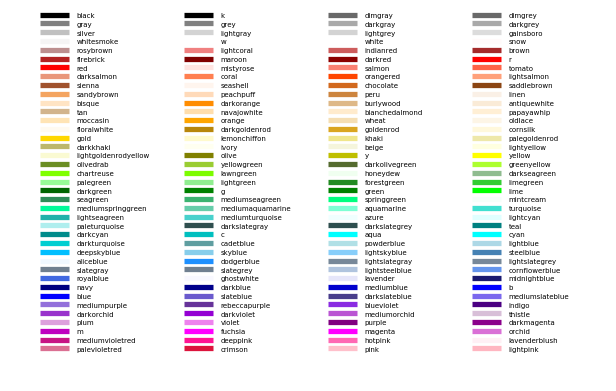

In [48]:
"""
========================
Visualizing named colors
========================

Simple plot example with the named colors and its visual representation.
"""
from __future__ import division

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

n = len(sorted_names)
ncols = 4
nrows = n // ncols + 1

fig, ax = plt.subplots(figsize=(8, 5))

# Get height and width
X, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (nrows + 1)
w = X / ncols

for i, name in enumerate(sorted_names):
    col = i % ncols
    row = i // ncols
    y = Y - (row * h) - h

    xi_line = w * (col + 0.05)
    xf_line = w * (col + 0.25)
    xi_text = w * (col + 0.3)

    ax.text(xi_text, y, name, fontsize=(h * 0.8),
            horizontalalignment='left',
            verticalalignment='center')

    ax.hlines(y + h * 0.1, xi_line, xf_line,
              color=colors[name], linewidth=(h * 0.6))

ax.set_xlim(0, X)
ax.set_ylim(0, Y)
ax.set_axis_off()

fig.subplots_adjust(left=0, right=1,
                    top=1, bottom=0,
                    hspace=0, wspace=0)
plt.show()

In [70]:
colors.items()

dict_items([('b', (0, 0, 1)), ('g', (0, 0.5, 0)), ('r', (1, 0, 0)), ('c', (0, 0.75, 0.75)), ('m', (0.75, 0, 0.75)), ('y', (0.75, 0.75, 0)), ('k', (0, 0, 0)), ('w', (1, 1, 1)), ('aliceblue', '#F0F8FF'), ('antiquewhite', '#FAEBD7'), ('aqua', '#00FFFF'), ('aquamarine', '#7FFFD4'), ('azure', '#F0FFFF'), ('beige', '#F5F5DC'), ('bisque', '#FFE4C4'), ('black', '#000000'), ('blanchedalmond', '#FFEBCD'), ('blue', '#0000FF'), ('blueviolet', '#8A2BE2'), ('brown', '#A52A2A'), ('burlywood', '#DEB887'), ('cadetblue', '#5F9EA0'), ('chartreuse', '#7FFF00'), ('chocolate', '#D2691E'), ('coral', '#FF7F50'), ('cornflowerblue', '#6495ED'), ('cornsilk', '#FFF8DC'), ('crimson', '#DC143C'), ('cyan', '#00FFFF'), ('darkblue', '#00008B'), ('darkcyan', '#008B8B'), ('darkgoldenrod', '#B8860B'), ('darkgray', '#A9A9A9'), ('darkgreen', '#006400'), ('darkgrey', '#A9A9A9'), ('darkkhaki', '#BDB76B'), ('darkmagenta', '#8B008B'), ('darkolivegreen', '#556B2F'), ('darkorange', '#FF8C00'), ('darkorchid', '#9932CC'), ('darkre

In [97]:
import re
re_color = re.compile('#([0-9a-f]{2})([0-9a-f]{2})([0-9a-f]{2})')
from math import sqrt

def color_to_rgb(color):
    return tuple(int(x, 16) / 255.0 for x in re_color.match(color).groups())

def similarity(color1, color2):
    """Computes the pearson correlation coefficient for two colors. The result
    will be between 1.0 (very similar) and -1.0 (no similarity)."""
    c1 = color_to_rgb(color1)
    c2 = color_to_rgb(color2)

    s1 = sum(c1)
    s2 = sum(c2)
    sp1 = sum(map(lambda c: pow(c, 2), c1))
    sp2 = sum(map(lambda c: pow(c, 2), c2))
    sp = sum(map(lambda x: x[0] * x[1], zip(c1, c2)))

    return (sp - (s1 * s2 / 3.0)) / sqrt((sp1 - pow(s1, 2) / 3.0) * (sp2 - pow(s2, 2) / 3.0))

color_names = {
    '#ff0000': 'red',
    '#00ff00': 'green',
    '#0000ff': 'blue'
    # add more color definitions here
}

def find_name(color):
    sim = [(similarity(color, c), name) for c, name in color_names.items()]
    return max(sim, key=lambda x: x[0])[1]

print(find_name('#cc0000')) # returns "red" 

red


In [73]:
re_color 

re.compile(r'#([0-9a-f]{2})([0-9a-f]{2})([0-9a-f]{2})', re.UNICODE)

In [185]:
# Get color name from RGB
# https://stackoverflow.com/questions/2453344/find-the-colour-name-from-a-hexadecimal-colour-code

colorof = {'#F0F8FF':"aliceblue",
'#FAEBD7':"antiquewhite",
'#00FFFF':"aqua",
'#7FFFD4':"aquamarine",
'#F0FFFF':"azure",
'#F5F5DC':"beige",
'#FFE4C4':"bisque",
'#000000':"black",
'#FFEBCD':"blanchedalmond",
'#0000FF':"blue",
'#8A2BE2':"blueviolet",
'#A52A2A':"brown",
'#DEB887':"burlywood",
'#5F9EA0':"cadetblue",
'#7FFF00':"chartreuse",
'#D2691E':"chocolate",
'#FF7F50':"coral",
'#6495ED':"cornflowerblue",
'#FFF8DC':"cornsilk",
'#DC143C':"crimson",
'#00FFFF':"cyan",
'#00008B':"darkblue",
'#008B8B':"darkcyan",
'#B8860B':"darkgoldenrod",
'#A9A9A9':"darkgray",
'#006400':"darkgreen",
'#BDB76B':"darkkhaki",
'#8B008B':"darkmagenta",
'#556B2F':"darkolivegreen",
'#FF8C00':"darkorange",
'#9932CC':"darkorchid",
'#8B0000':"darkred",
'#E9967A':"darksalmon",
'#8FBC8B':"darkseagreen",
'#483D8B':"darkslateblue",
'#2F4F4F':"darkslategray",
'#00CED1':"darkturquoise",
'#9400D3':"darkviolet",
'#FF1493':"deeppink",
'#00BFFF':"deepskyblue",
'#696969':"dimgray",
'#1E90FF':"dodgerblue",
'#B22222':"firebrick",
'#FFFAF0':"floralwhite",
'#228B22':"forestgreen",
'#FF00FF':"fuchsia",
'#DCDCDC':"gainsboro",
'#F8F8FF':"ghostwhite",
'#FFD700':"gold",
'#DAA520':"goldenrod",
'#808080':"gray",
'#008000':"green",
'#ADFF2F':"greenyellow",
'#F0FFF0':"honeydew",
'#FF69B4':"hotpink",
'#CD5C5C':"indianred",
'#4B0082':"indigo",
'#FFFFF0':"ivory",
'#F0E68C':"khaki",
'#E6E6FA':"lavender",
'#FFF0F5':"lavenderblush",
'#7CFC00':"lawngreen",
'#FFFACD':"lemonchiffon",
'#ADD8E6':"lightblue",
'#F08080':"lightcoral",
'#E0FFFF':"lightcyan",
'#FAFAD2':"lightgoldenrodyellow",
'#D3D3D3':"lightgray",
'#90EE90':"lightgreen",
'#FFB6C1':"lightpink",
'#FFA07A':"lightsalmon",
'#20B2AA':"lightseagreen",
'#87CEFA':"lightskyblue",
'#778899':"lightslategray",
'#B0C4DE':"lightsteelblue",
'#FFFFE0':"lightyellow",
'#00FF00':"lime",
'#32CD32':"limegreen",
'#FAF0E6':"linen",
'#FF00FF':"magenta",
'#800000':"maroon",
'#66CDAA':"mediumaquamarine",
'#0000CD':"mediumblue",
'#BA55D3':"mediumorchid",
'#9370DB':"mediumpurple",
'#3CB371':"mediumseagreen",
'#7B68EE':"mediumslateblue",
'#00FA9A':"mediumspringgreen",
'#48D1CC':"mediumturquoise",
'#C71585':"mediumvioletred",
'#191970':"midnightblue",
'#F5FFFA':"mintcream",
'#FFE4E1':"mistyrose",
'#FFE4B5':"moccasin",
'#FFDEAD':"navajowhite",
'#000080':"navy",
'#FDF5E6':"oldlace",
'#808000':"olive",
'#6B8E23':"olivedrab",
'#FFA500':"orange",
'#FF4500':"orangered",
'#DA70D6':"orchid",
'#EEE8AA':"palegoldenrod",
'#98FB98':"palegreen",
'#AFEEEE':"paleturquoise",
'#DB7093':"palevioletred",
'#FFEFD5':"papayawhip",
'#FFDAB9':"peachpuff",
'#CD853F':"peru",
'#FFC0CB':"pink",
'#DDA0DD':"plum",
'#B0E0E6':"powderblue",
'#800080':"purple",
'#FF0000':"red",
'#BC8F8F':"rosybrown",
'#4169E1':"royalblue",
'#8B4513':"saddlebrown",
'#FA8072':"salmon",
'#F4A460':"sandybrown",
'#2E8B57':"seagreen",
'#FFF5EE':"seashell",
'#A0522D':"sienna",
'#C0C0C0':"silver",
'#87CEEB':"skyblue",
'#6A5ACD':"slateblue",
'#708090':"slategray",
'#FFFAFA':"snow",
'#00FF7F':"springgreen",
'#4682B4':"steelblue",
'#D2B48C':"tan",
'#008080':"teal",
'#D8BFD8':"thistle",
'#FF6347':"tomato",
'#40E0D0':"turquoise",
'#EE82EE':"violet",
'#F5DEB3':"wheat",
'#FFFFFF':"white",
'#F5F5F5':"whitesmoke",
'#FFFF00':"yellow",
'#9ACD32':"yellowgreen"}


def get_rgb_color_name(rgb):
    
    xy = rgb_to_hex(rgb)
    hx = xy[1:8]
    print(hx)
    # if color is found in dict
    if colorof.get(hx):return colorof[hx]

    # else return its closest available color
    m = 16777215
    k = '000000'
    for key in colorof.keys():
        key_color = key[1:8]
        #print(key_color)
        a = int(hx[:2],16)-int(key_color[:2],16)
        b = int(hx[2:4],16)-int(key_color[2:4],16)
        c = int(hx[4:],16)-int(key_color[4:],16)

        v = a*a+b*b+c*c # simple measure for distance between colors

        # v = (r1 - r2)^2 + (g1 - g2)^2 + (b1 - b2)^2

        if v <= m:
            m = v
            k = key

    return colorof[k]

rgb_1 = (247, 255, 255)
print('Found:',    get_rgb_color_name(rgb_1))     # found in dict
print('closest :', get_rgb_color_name(rgb_1))   # closest to Antique white

RGB : (247, 255, 255)   Hex Dec: #f7ffff
f7ffff
Found: mintcream
RGB : (247, 255, 255)   Hex Dec: #f7ffff
f7ffff
closest : mintcream


In [182]:
# RGB to Hex Decimal
def rgb_to_hex(rgb):
    
    rgb_int = bytes(rgb).hex()
    rgb_dec = '#'+str(rgb_int)
    print('RGB :',rgb, '  Hex Dec:', rgb_dec)
    return rgb_dec

rgb = (254, 250, 255)
rgb_dec = rgb_to_hex(rgb)

RGB : (254, 250, 255)   Hex Dec: #fefaff


In [168]:
# Array to list
rgb_3 = rgb_to_hex(rgb)
rgb_3

[254, 250, 255]

In [171]:
y=np.array(rgb)
y

array([254, 250, 255])

In [167]:
type(rgb_3)

list

In [186]:
rgb = (254, 250, 255)
rgb_dec = bytes(rgb).hex()
print('RGB :',rgb, '  Hex Dec:', rgb_dec)

RGB : (254, 250, 255)   Hex Dec: fefaff


# Plot Histogram

In [14]:
# Path to the image files
folder = "Test_image02"
path = mypath + "/" + folder + "/"
path
xfile = 'Enh_Copper_1.jpg'
file1 = path + xfile

In [15]:
img = cv2.imread(file1,0)
hist = cv2.calcHist([img],[0],None,[256],[0,256])

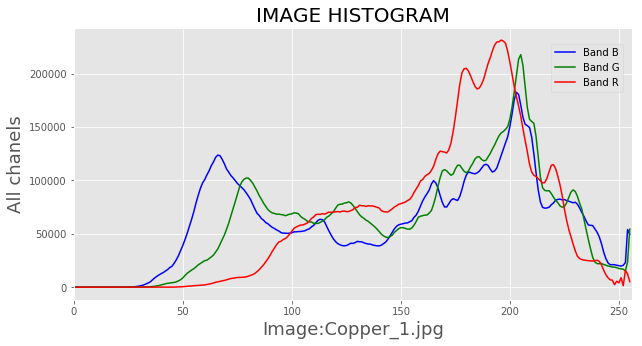

In [210]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html
import cv2
import numpy as np
from matplotlib import pyplot as plt

def print_matplot_hist(path, xfile):
       
    img = cv2.imread(path+xfile)
    color = ('b','g','r')
    plt.figure(figsize=(10,5))
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col, label='Band '+col.upper())
        plt.xlim([0,256])
      

    plt.title('IMAGE HISTOGRAM',fontsize=20)
    plt.xlabel('Image:'+xfile,fontsize=18)
    plt.ylabel('All chanels',fontsize=18)
    plt.legend(bbox_to_anchor=(.78,0.85),bbox_transform=plt.gcf().transFigure)

    plt.savefig(path+'Hist_'+xfile)   # Save Histograme Figure
    plt.show()
    return  

xfile = 'Copper_1.jpg'
print_matplot_hist(path, xfile)

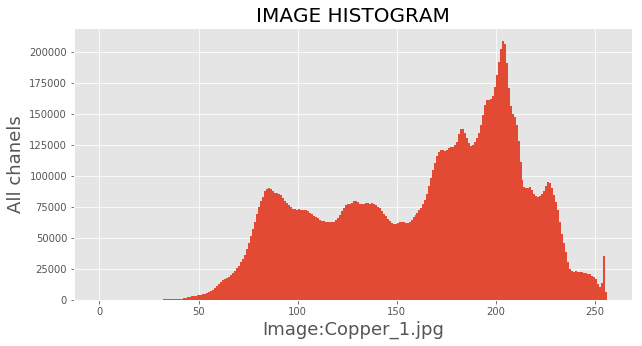

In [202]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def histogram_print2(path, xfile):
    plt.figure(figsize=(10,5))

    img = cv2.imread(path+xfile,0)
    plt.hist(img.ravel(),256,[0,256])

    plt.title('IMAGE HISTOGRAM',fontsize=20)
    plt.xlabel('Image:'+xfile,fontsize=18)
    plt.ylabel('All chanels',fontsize=18)
    plt.show()
    return

xfile = 'Copper_1.jpg'
histogram_print2(path, xfile)

In [198]:
# Valor maximo e minimo do Histograma e sua posição
l = np.array(zy).tolist()

val_max, idx_max, val_min, idx_min = histograma_max_min(l)
print("Valor Max Histograma:", val_max, '  Posição do valor Max:', idx_max)
print("Valor Min Histograma:", val_min, '  Posição do valor Min:', idx_min)

TypeError: 'int' object is not subscriptable

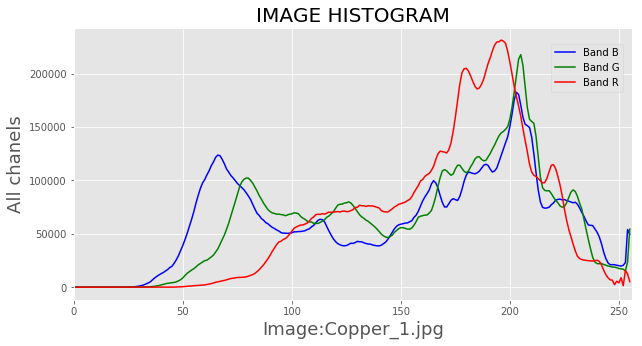

In [211]:
xfile = 'Copper_1.jpg'
print_matplot_hist(path, xfile)


In [118]:
path

'C:\\Users\\manuel.robalinho\\Google Drive\\UPT_Portucalense\\Trabalho final\\Classificacao_Sucata\\Jupyter_Notebook/Test_image02/'

In [ ]:
# Valor maximo e minimo do Histograma e sua posição
l = np.array(hist_full).tolist()

val_max, idx_max, val_min, idx_min = histograma_max_min(l)
print("Valor Max Histograma:", val_max, '  Posição do valor Max:', idx_max)
print("Valor Min Histograma:", val_min, '  Posição do valor Min:', idx_min)

# Histogram wih OPENCV

In [121]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html
# Print histogram using Opencv
import cv2
import numpy as np
from matplotlib import pyplot as plt

def print_cv_hist(path, xfile):
    file1 = path+xfile
    print('Hist cv2:', path, xfile)
    img = cv2.imread(file1,0)

    # create a mask
    mask = np.zeros(img.shape[:2], np.uint8)

    # define area to extract image from original
    mask[700:2500, 1000:5000] = 255
    masked_img = cv2.bitwise_and(img,img,mask = mask)

    # Calculate histogram with mask and without mask
    # Check third argument for mask
    hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
    hist_mask = cv2.calcHist([img],[0],mask,[256],[0,256])

    plt.figure(figsize=(18,5))

    plt.subplot(141), plt.imshow(img, 'gray')
    plt.title("Original")

    plt.subplot(142), plt.imshow(mask,'gray')
    plt.title('Mask')

    plt.subplot(143), plt.imshow(masked_img, 'gray')
    plt.title('Masked image')

    plt.subplot(144), plt.plot(hist_full), plt.plot(hist_mask)
    plt.title('Histogram')
    plt.xlim([0,256])

    plt.suptitle('IMAGE HISTOGRAM',fontsize=18)
    plt.xlabel('Image:'+xfile,fontsize=18)
    plt.ylabel('All chanels',fontsize=10)
    plt.savefig(path+'Hist_cv2_'+xfile)   # Save Histograme Figure
    plt.show()
    return

#print_cv_hist(path, xfile)

Hist cv2: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/ Copper_1.jpg


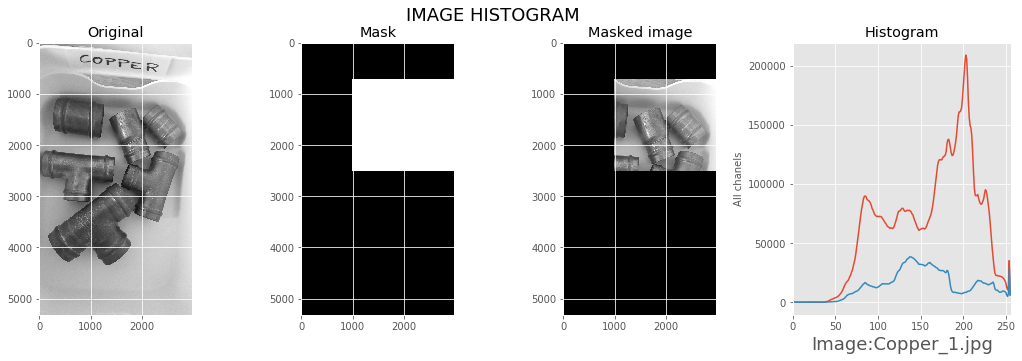

In [212]:
xfile = 'Copper_1.jpg'
print_cv_hist(path, xfile)

In [222]:
# Max and Min value from Histogram and each position
#l = np.array(hist_full).tolist()  - Transform array in a list

import cv2
import numpy as np
from matplotlib import pyplot as plt

def histograma_max_min(path, xfile):

    file1 = path+xfile
    print('Histogram analisys:', xfile)
    img = cv2.imread(file1,0)

    # Calculate histogram without mask
    hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
 
    # Transform array in a list
    hist_list = np.array(hist_full).tolist()

    # Valor maximo e minimo do Histograma e sua posição
    val_max = max(hist_list)
    xval_max = int(val_max[0])
    val_min = min(hist_list)
    xval_min = int(val_min[0])
    idx_max = hist_list.index(val_max)
    idx_min = hist_list.index(val_min)
    
    #print("Valor Max Histograma:", xval_max, '  Posição do valor Max:', idx_max)
    #print("Valor Min Histograma:", xval_min, '  Posição do valor Min:', idx_min)
    return xval_max, idx_max, xval_min, idx_min

Hist cv2: C:\Users\manuel.robalinho\Google Drive\UPT_Portucalense\Trabalho final\Classificacao_Sucata\Jupyter_Notebook/Test_image02/ Copper_1.jpg


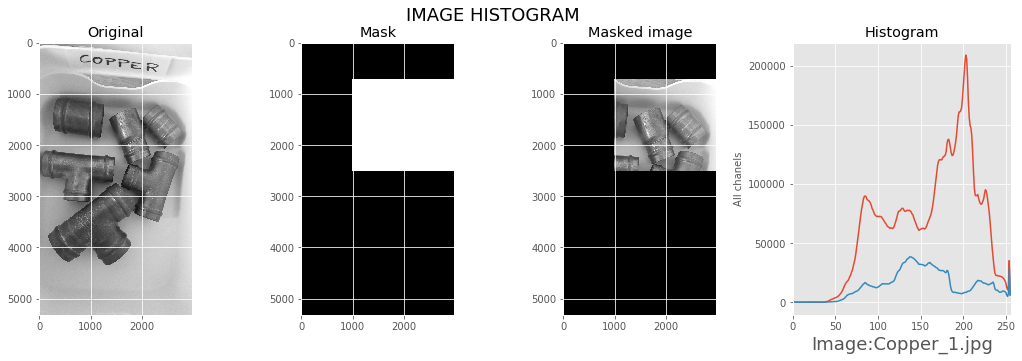

In [140]:
xfile = 'Copper_1.jpg'
print_cv_hist(path, xfile)

In [170]:
x1 = np.array(hist_full).tolist()
x2 = sorted(x1, reverse=True)
x2

[[2258120.0],
 [258909.0],
 [199057.0],
 [150929.0],
 [131867.0],
 [119171.0],
 [107120.0],
 [107044.0],
 [105139.0],
 [104934.0],
 [103132.0],
 [102842.0],
 [102814.0],
 [100451.0],
 [99903.0],
 [97764.0],
 [96532.0],
 [95419.0],
 [94648.0],
 [91925.0],
 [88923.0],
 [86088.0],
 [86005.0],
 [85197.0],
 [85080.0],
 [83920.0],
 [83806.0],
 [83748.0],
 [82983.0],
 [81030.0],
 [80945.0],
 [80701.0],
 [80628.0],
 [80568.0],
 [80054.0],
 [79860.0],
 [79472.0],
 [79271.0],
 [79196.0],
 [77404.0],
 [76078.0],
 [75975.0],
 [75963.0],
 [74599.0],
 [73452.0],
 [71293.0],
 [71255.0],
 [70406.0],
 [69798.0],
 [69687.0],
 [69581.0],
 [69172.0],
 [68882.0],
 [68716.0],
 [68622.0],
 [68319.0],
 [67775.0],
 [67706.0],
 [67421.0],
 [66872.0],
 [66645.0],
 [66346.0],
 [65905.0],
 [65827.0],
 [65374.0],
 [65371.0],
 [65002.0],
 [64539.0],
 [63589.0],
 [63539.0],
 [63514.0],
 [63263.0],
 [63152.0],
 [62824.0],
 [62822.0],
 [62520.0],
 [62255.0],
 [62250.0],
 [62128.0],
 [61960.0],
 [61889.0],
 [61885.0],
 

In [221]:
# Valor maximo e minimo do Histograma e sua posição
#l = np.array(hist_full).tolist()

xfile = 'Copper_1.jpg'
val_max, idx_max, val_min, idx_min = histograma_max_min(path, xfile)
print("Valor Max Histograma:", val_max, '  Posição do valor Max:', idx_max)
print("Valor Min Histograma:", val_min, '  Posição do valor Min:', idx_min)


Histogram analisys: Copper_1.jpg
Valor Max Histograma: 208904   Posição do valor Max: 203
Valor Min Histograma: 0   Posição do valor Min: 0


<Figure size 1296x360 with 0 Axes>

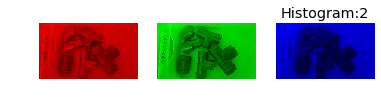

In [136]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

xfile = 'Copper_1.jpg'
plt.figure(figsize=(18,5))
img1 = np.array(Image.open(path+xfile))

figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(img1.shape, dtype='uint8')
    temp[:,:,i] = img1[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

(array([10.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0., 30.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

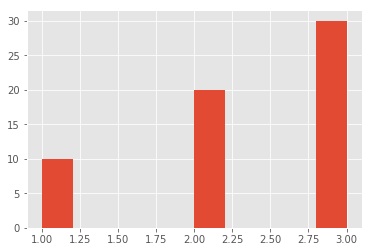

In [138]:
import numpy as np
import matplotlib.pyplot as plt
a = np.concatenate([np.ones(10), 2*np.ones(20), 3*np.ones(30)])
plt.hist(a)